In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Layer


import tensorflow as tf


In [22]:

#latent_dim = 2

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28 * 28))
x_test = np.reshape(x_test, (-1, 28 * 28))


latent_dim = 2
input_dim = 28 * 28
batch_size = 128
epochs = 25
learning_rate = 1e-3


inputs = Input(shape=(input_dim,))
h = Dense(256, activation='relu')(inputs)
h = Dense(128, activation='relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)



def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0., stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon



z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


decoder_h = Dense(128, activation='relu')
decoder_h2 = Dense(256, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')

h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_mean(h_decoded)






class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.reconstruction_loss_fn = BinaryCrossentropy()

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs

        reconstruction_loss = self.reconstruction_loss_fn(x, x_decoded_mean) * input_dim

        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return x_decoded_mean


vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])


vae = Model(inputs, vae_loss_layer)


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))


vae.summary()



Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 256)            │        200,960 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 128)            │         32,896 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 2)              │            258 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 2)              │            258 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 2)              │              0 │ dense_23[0][0],        │
│                           │                        │                │ dense_24[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 128)            │            384 │ lambda_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)          │ (None, 256)            │         33,024 │ dense_25[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_27 (Dense)          │ (None, 784)            │        201,488 │ dense_26[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_3          │ (None, 784)            │              0 │ input_layer_3[0][0],   │
│ (VAELossLayer)            │                        │                │ dense_27[0][0],        │
│                           │                        │                │ dense_23[0][0],        │
│                           │                        │                │ dense_24[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 469,268 (1.79 MB)

 Trainable params: 469,268 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 237.4702 - val_loss: 169.5417
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 167.6038 - val_loss: 163.2164
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 161.5620 - val_loss: 157.9733
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 156.8528 - val_loss: 155.5758
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 154.0751 - val_loss: 153.7177
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 152.9092 - val_loss: 152.1260
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 151.6657 - val_loss: 151.1442
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150.3841 - val_loss: 150.0960
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149.2768 - val_loss: 148.9884
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147.9371 - val_loss: 148.7619
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 147.1814 - val_loss: 147.8555
Epoch 12

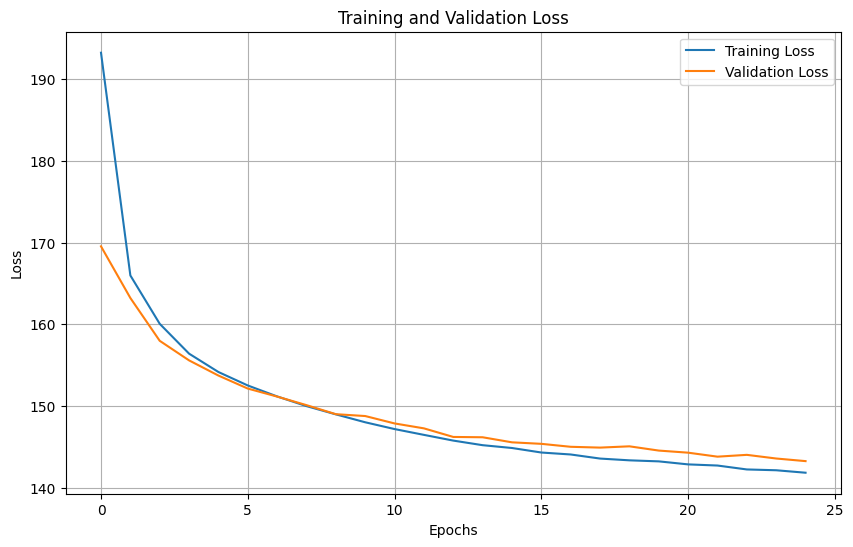

Model saved to vae_mnist.h5


In [23]:
#latent_dim = 2
history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test), verbose=1)

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



vae.save("vae_mnist.h5")
print("Model saved to vae_mnist.h5")


In [24]:
#latent_dim = 2
reconstructed_train = vae.predict(x_train)
reconstructed_test = vae.predict(x_test)


threshold = 0.5
train_accuracy = np.mean((x_train > threshold) == (reconstructed_train > threshold))
test_accuracy = np.mean((x_test > threshold) == (reconstructed_test > threshold))


print(f"Training Reconstruction Accuracy: {train_accuracy:.4f}")
print(f"Testing Reconstruction Accuracy: {test_accuracy:.4f}")

mse = mean_squared_error(x_test, reconstructed_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training Reconstruction Accuracy: 0.9222
Testing Reconstruction Accuracy: 0.9209


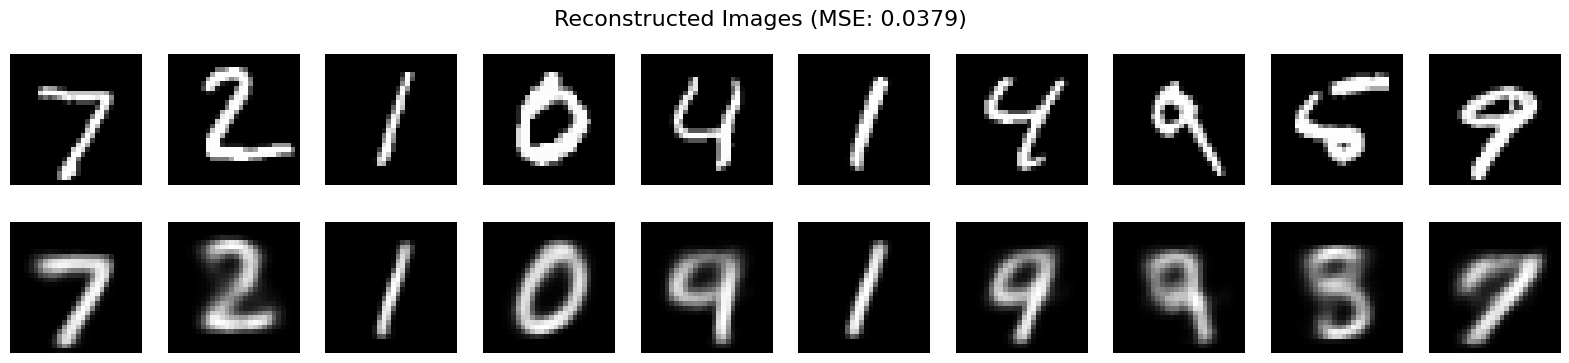

Mean Squared Error (MSE) for reconstructed images: 0.0379


In [25]:
#latent_dim = 2
mse = np.mean(np.square(x_test - reconstructed_test))


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle(f'Reconstructed Images (MSE: {mse:.4f})', fontsize=16)
plt.show()

print(f"Mean Squared Error (MSE) for reconstructed images: {mse:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


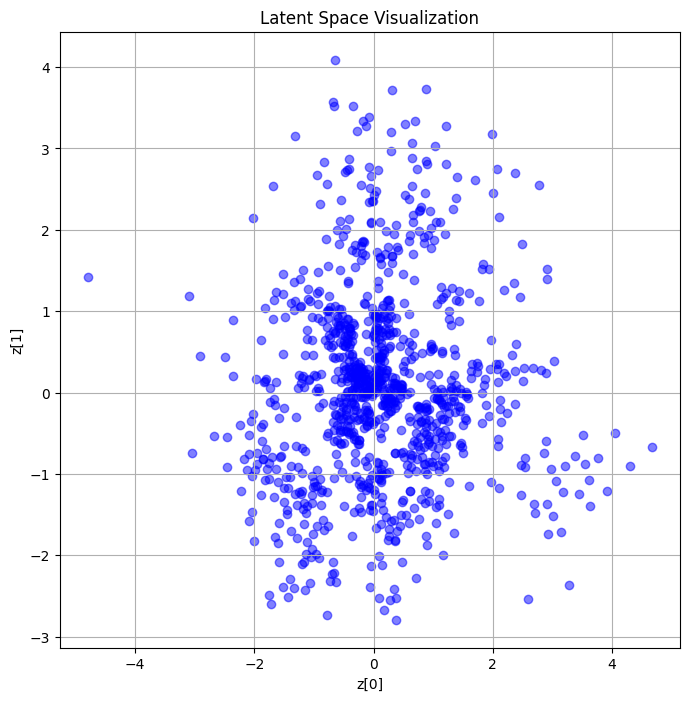

In [26]:
#latent_dim = 2
import matplotlib.pyplot as plt
import numpy as np


def plot_hidden_space(encoder, x_data, n_samples=1000):

    idx = np.random.choice(x_data.shape[0], n_samples, replace=False)
    sampled_data = x_data[idx]


    z_mean = encoder.predict(sampled_data, batch_size=batch_size)


    plt.figure(figsize=(8, 8))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], alpha=0.5, c="blue")
    plt.title("Latent Space Visualization")
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.grid(True)
    plt.show()


encoder = Model(inputs, z_mean)


plot_hidden_space(encoder, x_test)


In [27]:


#latent_dim = 4

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28 * 28))
x_test = np.reshape(x_test, (-1, 28 * 28))


latent_dim = 4
input_dim = 28 * 28
batch_size = 128
epochs = 25
learning_rate = 1e-3


inputs = Input(shape=(input_dim,))
h = Dense(256, activation="relu")(inputs)
h = Dense(128, activation="relu")(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


decoder_h = Dense(128, activation="relu")
decoder_h2 = Dense(256, activation="relu")
decoder_mean = Dense(input_dim, activation="sigmoid")

h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_mean(h_decoded)


class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.reconstruction_loss_fn = BinaryCrossentropy()

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs

        reconstruction_loss = self.reconstruction_loss_fn(x, x_decoded_mean) * input_dim

        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return x_decoded_mean


vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])


vae = Model(inputs, vae_loss_layer)


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))


vae.summary()


vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_28 (Dense)          │ (None, 256)            │        200,960 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 128)            │         32,896 │ dense_28[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_30 (Dense)          │ (None, 4)              │            516 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_31 (Dense)          │ (None, 4)              │            516 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_4 (Lambda)         │ (None, 4)              │              0 │ dense_30[0][0],        │
│                           │                        │                │ dense_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_32 (Dense)          │ (None, 128)            │            640 │ lambda_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_33 (Dense)          │ (None, 256)            │         33,024 │ dense_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_34 (Dense)          │ (None, 784)            │        201,488 │ dense_33[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_4          │ (None, 784)            │              0 │ input_layer_4[0][0],   │
│ (VAELossLayer)            │                        │                │ dense_34[0][0],        │
│                           │                        │                │ dense_30[0][0],        │
│                           │                        │                │ dense_31[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 470,040 (1.79 MB)

 Trainable params: 470,040 (1.79 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 230.3110 - val_loss: 152.2487
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149.2169 - val_loss: 142.1241
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 141.0775 - val_loss: 137.1528
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 137.0151 - val_loss: 134.6516
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 134.3392 - val_loss: 132.8253
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 132.6857 - val_loss: 131.5892
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131.1240 - val_loss: 130.6418
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 130.1300 - val_loss: 129.6962
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 129.2694 - val_loss: 128.9654
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 128.1570 - val_loss: 128.1234
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 127.7169 - val_loss: 127.5400
Epoch 1

In [28]:
#latent_dim = 4
reconstructed_train = vae.predict(x_train)
reconstructed_test = vae.predict(x_test)


threshold = 0.5
train_accuracy = np.mean((x_train > threshold) == (reconstructed_train > threshold))
test_accuracy = np.mean((x_test > threshold) == (reconstructed_test > threshold))


print(f"Training Reconstruction Accuracy: {train_accuracy:.4f}")
print(f"Testing Reconstruction Accuracy: {test_accuracy:.4f}")

mse = mean_squared_error(x_test, reconstructed_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Training Reconstruction Accuracy: 0.9406
Testing Reconstruction Accuracy: 0.9391


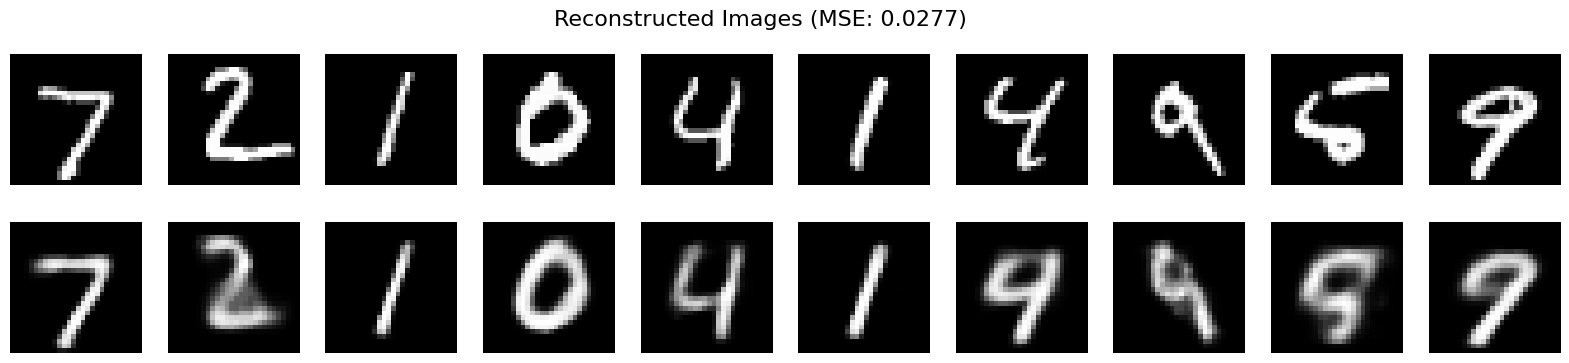

Mean Squared Error (MSE) for reconstructed images: 0.0277


In [29]:
#latent_dim = 4
mse = np.mean(np.square(x_test - reconstructed_test))


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle(f'Reconstructed Images (MSE: {mse:.4f})', fontsize=16)
plt.show()

print(f"Mean Squared Error (MSE) for reconstructed images: {mse:.4f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


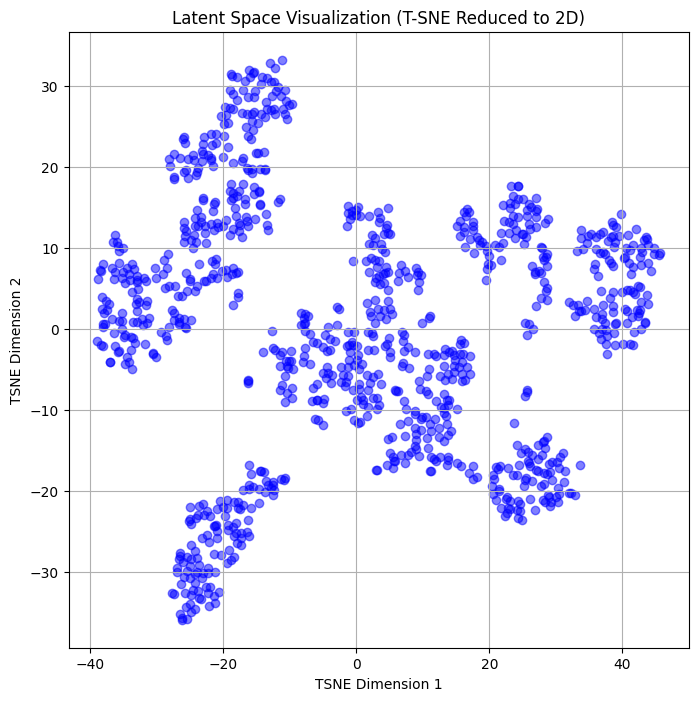

In [30]:
#latent_dim = 4
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


def plot_hidden_space_with_tsne(encoder, x_data, n_samples=1000, perplexity=30):


    idx = np.random.choice(x_data.shape[0], n_samples, replace=False)
    sampled_data = x_data[idx]


    z_mean = encoder.predict(sampled_data, batch_size=batch_size)


    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    z_tsne = tsne.fit_transform(z_mean)


    plt.figure(figsize=(8, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], alpha=0.5, c="blue")
    plt.title("Latent Space Visualization (T-SNE Reduced to 2D)")
    plt.xlabel("TSNE Dimension 1")
    plt.ylabel("TSNE Dimension 2")
    plt.grid(True)
    plt.show()


encoder = Model(inputs, z_mean)


plot_hidden_space_with_tsne(encoder, x_test)


In [31]:


#latent_dim = 16

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28 * 28))
x_test = np.reshape(x_test, (-1, 28 * 28))


latent_dim = 16
input_dim = 28 * 28
batch_size = 128
epochs = 25
learning_rate = 1e-3


inputs = Input(shape=(input_dim,))
h = Dense(256, activation="relu")(inputs)
h = Dense(128, activation="relu")(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)


def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])


decoder_h = Dense(128, activation="relu")
decoder_h2 = Dense(256, activation="relu")
decoder_mean = Dense(input_dim, activation="sigmoid")

h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
outputs = decoder_mean(h_decoded)


class VAELossLayer(Layer):
    def __init__(self, **kwargs):
        super(VAELossLayer, self).__init__(**kwargs)
        self.reconstruction_loss_fn = BinaryCrossentropy()

    def call(self, inputs):
        x, x_decoded_mean, z_mean, z_log_var = inputs

        reconstruction_loss = self.reconstruction_loss_fn(x, x_decoded_mean) * input_dim

        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return x_decoded_mean


vae_loss_layer = VAELossLayer()([inputs, outputs, z_mean, z_log_var])


vae = Model(inputs, vae_loss_layer)


vae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))


vae.summary()


vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, x_test))


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 784)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_35 (Dense)          │ (None, 256)            │        200,960 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_36 (Dense)          │ (None, 128)            │         32,896 │ dense_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_37 (Dense)          │ (None, 16)             │          2,064 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_38 (Dense)          │ (None, 16)             │          2,064 │ dense_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_5 (Lambda)         │ (None, 16)             │              0 │ dense_37[0][0],        │
│                           │                        │                │ dense_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_39 (Dense)          │ (None, 128)            │          2,176 │ lambda_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_40 (Dense)          │ (None, 256)            │         33,024 │ dense_39[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_41 (Dense)          │ (None, 784)            │        201,488 │ dense_40[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ vae_loss_layer_5          │ (None, 784)            │              0 │ input_layer_5[0][0],   │
│ (VAELossLayer)            │                        │                │ dense_41[0][0],        │
│                           │                        │                │ dense_37[0][0],        │
│                           │                        │                │ dense_38[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 474,672 (1.81 MB)

 Trainable params: 474,672 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 223.3577 - val_loss: 137.6166
Epoch 2/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 134.3837 - val_loss: 122.3468
Epoch 3/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121.6137 - val_loss: 116.0645
Epoch 4/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 116.1599 - val_loss: 112.8941
Epoch 5/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 112.9954 - val_loss: 110.5199
Epoch 6/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 111.0240 - val_loss: 109.5791
Epoch 7/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 109.5128 - val_loss: 108.2552
Epoch 8/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 108.5860 - val_loss: 107.2219
Epoch 9/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 107.3946 - val_loss: 106.5490
Epoch 10/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 106.9643 - val_loss: 106.1145
Epoch 11/25
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 106.4861 - val_loss: 105.3679
Epoch 1

In [32]:
#latent_dim = 16
reconstructed_train = vae.predict(x_train)
reconstructed_test = vae.predict(x_test)


threshold = 0.5
train_accuracy = np.mean((x_train > threshold) == (reconstructed_train > threshold))
test_accuracy = np.mean((x_test > threshold) == (reconstructed_test > threshold))


print(f"Training Reconstruction Accuracy: {train_accuracy:.4f}")
print(f"Testing Reconstruction Accuracy: {test_accuracy:.4f}")

mse = mean_squared_error(x_test, reconstructed_test)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Training Reconstruction Accuracy: 0.9646
Testing Reconstruction Accuracy: 0.9644


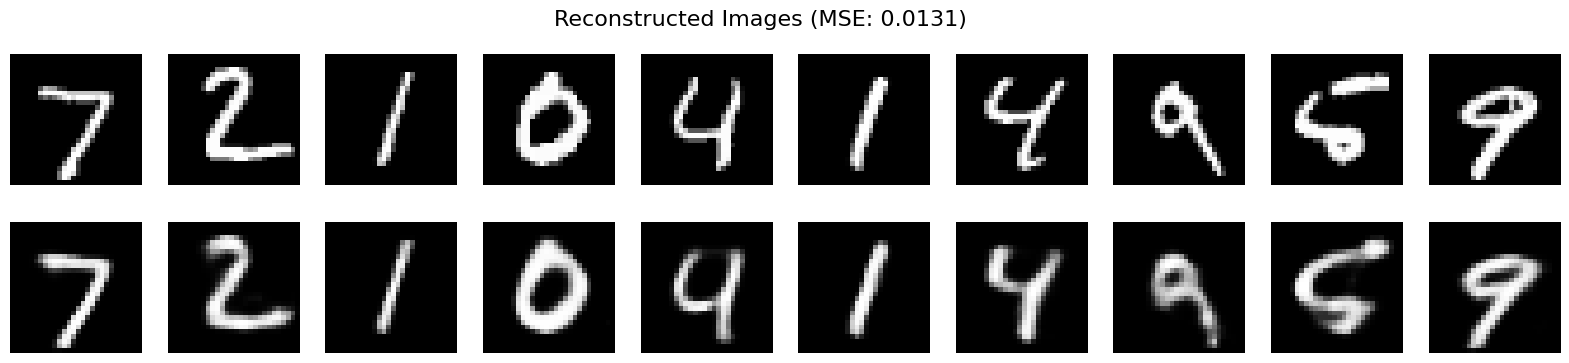

Mean Squared Error (MSE) for reconstructed images: 0.0131


In [33]:
#latent_dim = 16
mse = np.mean(np.square(x_test - reconstructed_test))


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

plt.suptitle(f'Reconstructed Images (MSE: {mse:.4f})', fontsize=16)
plt.show()

print(f"Mean Squared Error (MSE) for reconstructed images: {mse:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


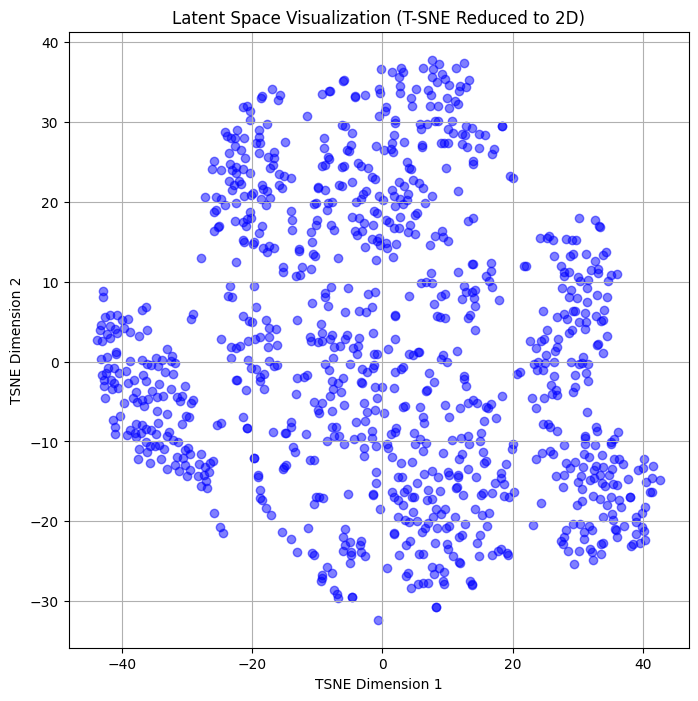

In [34]:
#latent_dim = 16
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE


def plot_hidden_space_with_tsne(encoder, x_data, n_samples=1000, perplexity=30):


    idx = np.random.choice(x_data.shape[0], n_samples, replace=False)
    sampled_data = x_data[idx]


    z_mean = encoder.predict(sampled_data, batch_size=batch_size)


    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    z_tsne = tsne.fit_transform(z_mean)


    plt.figure(figsize=(8, 8))
    plt.scatter(z_tsne[:, 0], z_tsne[:, 1], alpha=0.5, c="blue")
    plt.title("Latent Space Visualization (T-SNE Reduced to 2D)")
    plt.xlabel("TSNE Dimension 1")
    plt.ylabel("TSNE Dimension 2")
    plt.grid(True)
    plt.show()


encoder = Model(inputs, z_mean)


plot_hidden_space_with_tsne(encoder, x_test)
